In [2]:
#%matplotlib inline
import os
from time import sleep
from datetime import datetime

#para plotar o grafico em real time
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import style
#style.use('fivethirtyeight')

import matplotlib.pyplot as plt
import numpy as np
import qcodes as qc
from qcodes import (
    Measurement,
    experiments,
    initialise_database,
    initialise_or_create_database_at,
    load_by_guid,
    load_by_run_spec,
    load_experiment,
    load_last_experiment,
    load_or_create_experiment,
    new_experiment,
)
from qcodes.dataset.plotting import plot_dataset
from qcodes.logger.logger import start_all_logging
from qcodes.tests.instrument_mocks import DummyInstrument
from qcodes.instrument.parameter import Parameter

Logging hadn't been started.
Activating auto-logging. Current session state plus future input saved.
Filename       : /home/daniel/.qcodes/logs/command_history.log
Mode           : append
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active
Qcodes Logfile : /home/daniel/.qcodes/logs/201020-2548-qcodes.log


In [3]:
start_all_logging()
from qcodes import config
config.logger.start_logging_on_import = 'always'
config.save_to_home()

Activating auto-logging. Current session state plus future input saved.
Filename       : /home/daniel/.qcodes/logs/command_history.log
Mode           : append
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active
Qcodes Logfile : /home/daniel/.qcodes/logs/201020-2548-qcodes.log


In [4]:
initialise_or_create_database_at("./OneTone.db")

In [5]:
station = qc.Station()

In [6]:
# A dummy instrument dac with two parameters ch1 and ch2
dac = DummyInstrument('dac', gates=['amp'])

# A dummy instrument dmm with two parameters ch1 and Ch2
dmm = DummyInstrument('dmm', gates=['v1'])

In [7]:
#These are the parameters which come ready to use from the intruments drivers
#dac.add_parameter('amp',label='Amplitude', unit="V", get_cmd=None, set_cmd=None)
dac.add_parameter('freq',label='Frequency', unit="Hz", get_cmd=None, set_cmd=None)

In [8]:
#assigns values no the parameters
dac.amp(5)
dac.freq(200)

In [9]:
dac.print_readable_snapshot()

dac:
	parameter value
--------------------------------------------------------------------------------
IDN  :	None 
amp  :	5 (V)
freq :	200 (Hz)


In [10]:
station.add_component(dac)
station.add_component(dmm)

'dmm'

In [11]:
#in this class is defined the simulated behavior of the osciloscope entrance
class dmm_parameter(qc.Parameter):
    def __init__(self, name):
        super().__init__(name)
        #assingns the generator to self.ed
        self.ed = self.exponential_decay(0.01, 0.01)
        next(self.ed)
        self.memory=0

    #gets value automatically from dac channel 1
    def get_raw(self):
        shift=0
        """
        This method is automatically wrapped to
        provide a ``get`` method on the parameter instance.
        """
        #if the amp and thus the power is greater than a value 
        #the qubit punches out the frequency
        if(dac.amp()>10):
            shift=5
        val = self.ed.send(dac.freq()-shift)*dac.amp()
        next(self.ed)
        return val

    #this function returns an generator which is a kind of iterable
    def exponential_decay(self, a: float, b: float):
        """
        Yields a*exp(-b*x) where x is put in
        """
        x = 0
        while True:
            x = yield
            #yield returns a generator
            yield a*np.exp(-b*(x-15)**2) + 0.02*a*np.random.randn()
            
    
dmm.v1 = dmm_parameter('dmm_v1')

In [12]:

#puts current time in a string to facilitate control of the samples
now = datetime.now()
now = now.strftime("%Y-%m-%d_%H-%M-%S")
print(now)

2020-10-20_18-38-36


In [13]:
#the experiment is a unit of data inside the database it's made 
#out of samples or datasets
exp = load_or_create_experiment(experiment_name='One Tone',
                                sample_name=now)
# load_experiment_by_name(experiment_name='dataset_context_manager',sample_name="no sample")
# load_last_experiment()
# load_experiment(1)
# new_experiment(experiment_name='dataset_context_manager',sample_name="no sample")

In [79]:
#plot axis to make the points appear in the same graph
fig = plt.figure()
ax1 = fig.add_subplot()


In [ ]:

#plots the graph of the not punched out
ax1.plot(Z, W,c='blue')
plt.pause(0.01)

In [80]:
dac.amp(12)# amp > 10 means it punches out in the simu
meas = Measurement(exp=exp, station=station)
meas.register_parameter(dac.freq)  # register the first independent parameter
meas.register_parameter(dac.amp)
meas.register_parameter(dmm.v1, setpoints=(dac.freq,))  # now register the dependent oone

meas.write_period = 2 

with meas.run() as datasaver:
    #np.linspace is the interval and number of points in the osciloscope
    for set_v in np.linspace(0, 30, 60):
        #sets dac ch1 with the set_v value and gets value from v1
        dac.freq.set(set_v)
        get_v = dmm.v1.get()
        #adds to the datasaver the result
        datasaver.add_result((dac.freq, set_v),
                             (dmm.v1, get_v))

        sleep(0.1)
        #plots graph in real time
        #checks there is any data already
        if (bool(datasaver.dataset.get_parameter_data()['dmm_v1'])):
            #gets data from dataset to plot
            Y = datasaver.dataset.get_parameter_data()['dmm_v1']['dmm_v1']
            X = datasaver.dataset.get_parameter_data()['dmm_v1']['dac_freq']
            ax1.plot(X, Y,c='red')
            plt.pause(0.001)

    plt.show()
    datasaver.add_result((dac.amp, dac.amp()))

    dataset = datasaver.dataset  # convenient to have for plotting


Starting experimental run with id: 85. 


([<matplotlib.axes._subplots.AxesSubplot at 0x7feb0acd5dd8>], [None])

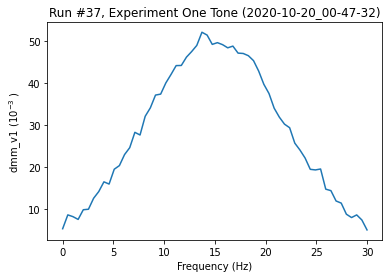

In [47]:
plot_dataset(dataset)

In [136]:
exp.data_sets

<bound method Experiment.data_sets of One Tone#2020-10-20_00-20-59#21@/home/daniel/Documents/Estudos/1Graduacao/Iniciação Cientifica - Computação Quântica/measurement-instruments-python/OneTone.db
--------------------------------------------------------------------------------------------------------------------------------------------------------------
25-results-1-dac_amp,dmm_v1-60>

In [ ]:
dataset = load_by_run_spec(experiment_name='One Tone', captured_run_id=4)

In [121]:
#api prototype
#this class will be supposed to execute the tasks above and serve
#as an api that you can import in a python instance or file and execute
class One_tone:
    def __init__(self, database="./OneTone.db"):
            #sets the defaults values
            self.database=database
            self.range=[0,100]
            self.amp_ground=2
            self.amp_excited=10
            
            print("database", self.database)
            self.print_setup()
            
    #methods to change the experiment setup values
#the max and min frequency sweeped by the experiment
    def freq_range(self, interval):
            self.range=interval
            self.print_setup()
#lower amplitude to sweep the cavity with the qubit in the ground state
    def ground_amp(self, interval):
            self.amp_ground=interval
            self.print_setup()

#higher amplitude to sweep qubit punched out in excited state    
    def excited_amp(self, interval):
            self.amp_excited=interval
            self.print_setup()
    
    
    #starts experiment
    def run(self):
            print("experiment was run \n graphs plotted")
    #prints the experiment setup values        
    def print_setup(self):
        print("freq_range",self.range, "| ground_amp", self.amp_ground,
                  "| excited_amp", self.amp_excited)
  
#declares the object of the class which will do the experiment
runN42=One_tone()


database ./OneTone.db
freq_range [0, 100] | ground_amp 2 | excited_amp 10


In [122]:
#assign range
runN42.freq_range([0,300])

freq_range [0, 300] | ground_amp 2 | excited_amp 10


In [123]:
runN42.ground_amp(1)

freq_range [0, 300] | ground_amp 1 | excited_amp 10


In [124]:
runN42.run()

experiment was ran 
 graphs plotted
